In [13]:
import torch
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from chainconsumer import Chain, ChainConfig, ChainConsumer, PlotConfig, Truth, make_sample
import pandas as pd

In [28]:
def affine_sample(log_prob, n_steps, current_state, args=[]):
    # split the current state
    current_state1, current_state2 = current_state
        
    # pull out the number of parameters and walkers
    n_walkers, n_params = current_state1.shape

    # initial target log prob for the walkers (and set any nans to -inf)...
    logp_current1 = log_prob(current_state1, *args)
    logp_current2 = log_prob(current_state2, *args)
    logp_current1 = torch.where(torch.isnan(logp_current1), torch.ones_like(logp_current1)*torch.log(torch.tensor(0.)), logp_current1)
    logp_current2 = torch.where(torch.isnan(logp_current2), torch.ones_like(logp_current2)*torch.log(torch.tensor(0.)), logp_current2)
    
    chain = [torch.unsqueeze(torch.cat([current_state1, current_state2], dim=0), dim=0)]
    
    
    for epoch in tqdm(range(1, n_steps), desc=f"{n_params} parameters, {n_walkers} walkers"):
        

        partners1 = torch.tensor(current_state2[torch.randint(0, n_walkers, (n_walkers,))])
        z1 = 0.5 * (torch.rand(n_walkers) + 1) ** 2
        # proposed_state1 = partners1 + (z1*(current_state1 - partners1).T).T
        proposed_state1 = partners1 + torch.transpose(z1*torch.transpose(current_state1 - partners1, 0, 1), 0, 1)
        
        # target log prob at proposed points
        logp_proposed1 = log_prob(proposed_state1, *args)
        logp_proposed1 = torch.where(torch.isnan(logp_proposed1), torch.ones_like(logp_proposed1)*torch.log(torch.tensor(0.)), logp_proposed1)
        
        # acceptance probability
        p_accept1 = torch.minimum(torch.ones(n_walkers), z1**(n_params-1)*torch.exp(logp_proposed1 - logp_current1) )
        
        # accept or not
        accept1_ = ((torch.rand(n_walkers)) <= p_accept1)
        accept1 = accept1_.to(torch.float32)
        
                # update the state
        # current_state1 = ( ((current_state1).T)*(1-accept1) + ((proposed_state1).T)*accept1).T
        current_state1 = torch.transpose( torch.transpose(current_state1, 0, 1)*(1-accept1) + torch.transpose(proposed_state1, 0, 1)*accept1, 0, 1)
        logp_current1 = torch.where(accept1_, logp_proposed1, logp_current1)

        # second set of walkers:

        # proposals
        partners2 = torch.tensor(current_state1[torch.randint(0, n_walkers, (n_walkers,))])
        z2 = 0.5 * (torch.rand(n_walkers) + 1) ** 2
        # proposed_state2 = partners2 + (z2*(current_state2 - partners2).T).T
        proposed_state2 = partners2 + torch.transpose(z2*torch.transpose(current_state2 - partners2, 0, 1), 0, 1)
        
        # target log prob at proposed points
        logp_proposed2 = log_prob(proposed_state2, *args)
        logp_proposed2 = torch.where(torch.isnan(logp_proposed2), torch.ones_like(logp_proposed2)*torch.log(torch.tensor(0.)), logp_proposed2)
        
        # acceptance probability
        p_accept2 = torch.minimum(torch.ones(n_walkers), z2**(n_params-1)*torch.exp(logp_proposed2 - logp_current2) )
        
        # accept or not
        accept2_ = ((torch.rand(n_walkers)) <= p_accept2)
        accept2 = accept2_.to(torch.float32)
        
        # update the state
        # current_state2 = ( ((current_state2).T)*(1-accept2) + ((proposed_state2).T)*accept2).T
        current_state2 = torch.transpose( torch.transpose(current_state2, 0, 1)*(1-accept2) + torch.transpose(proposed_state2, 0, 1)*accept2, 0, 1)
        logp_current2 = torch.where(accept2_, logp_proposed2, logp_current2)
        
        # append to chain
        chain.append(torch.unsqueeze(torch.cat([current_state1, current_state2], dim=0), dim=0))
        
        
    return torch.cat(chain, dim=0).detach().cpu().numpy()

        


        

In [45]:
def log_prob(x, mu = torch.tensor([0., 1.]), cov = torch.tensor([[1, 0.5], [0.5, 1]])):
    diff = x - mu
    return (-0.5 * (diff @ torch.linalg.inv(cov) @ diff.T)).diagonal()

In [46]:
print(log_prob(torch.linspace(0, 1, 100).reshape(-1, 2)).shape)
print(torch.linspace(0, 1, 100).reshape(-1, 2).shape)

torch.Size([50])
torch.Size([50, 2])


In [47]:
# # Example log probability function (simple Gaussian distribution)
# def example_log_prob(state, mean=0, std=1):
#     # A simple log probability for testing: Gaussian distribution
#     log_prob = -0.5 * torch.sum(((state - mean) / std) ** 2, dim=1) - state.shape[1] * torch.log(torch.tensor(2. * torch.pi)) - torch.log(torch.tensor(std))
#     return log_prob

# Initialize random states
n_walkers = 500
n_params = 2
n_steps = 1000
initial_state1 = torch.randn(n_walkers, n_params)
initial_state2 = torch.randn(n_walkers, n_params)
current_state = (initial_state1, initial_state2)


# Run the affine sample MCMC
chain = affine_sample(log_prob, n_steps, current_state)

# Show the shape of the resulting chain
# print(chain.shape)

2 parameters, 500 walkers:   0%|          | 0/999 [00:00<?, ?it/s]

/tmp/ipykernel_110417/37233504.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  partners1 = torch.tensor(current_state2[torch.randint(0, n_walkers, (n_walkers,))])
/tmp/ipykernel_110417/37233504.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  partners2 = torch.tensor(current_state1[torch.randint(0, n_walkers, (n_walkers,))])


In [48]:
chain = chain.reshape(-1, n_params)
print(chain.shape)


(1000000, 2)


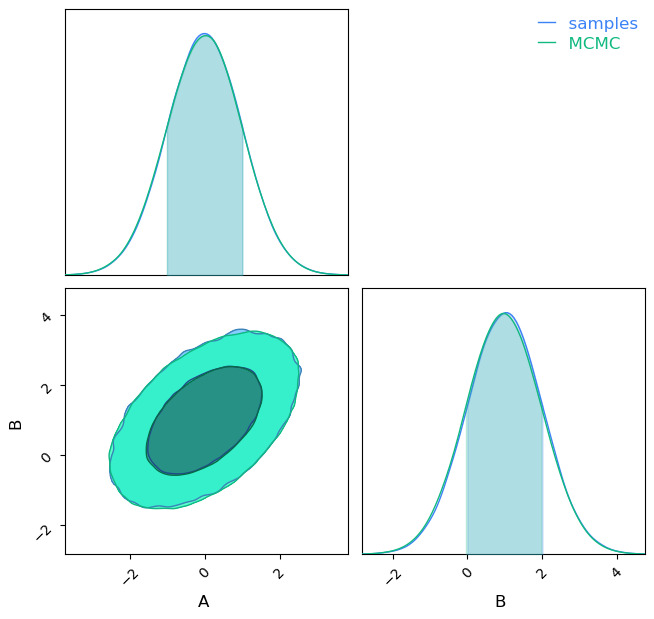

In [49]:
rd = np.random.multivariate_normal([0, 1], [[1, 0.5], [0.5, 1]], 100000)


c = ChainConsumer()
c.add_chain(Chain(samples=pd.DataFrame(rd, columns=['A', 'B']), name="samples"))
c.add_chain(Chain(samples=pd.DataFrame(chain, columns=['A', 'B']), name="MCMC"))
# fig = c.plotter.plot()
fig = c.plotter.plot()



(-4.7281082764303575,
 4.674220156840927,
 -3.9506104578862127,
 5.820318860070738)

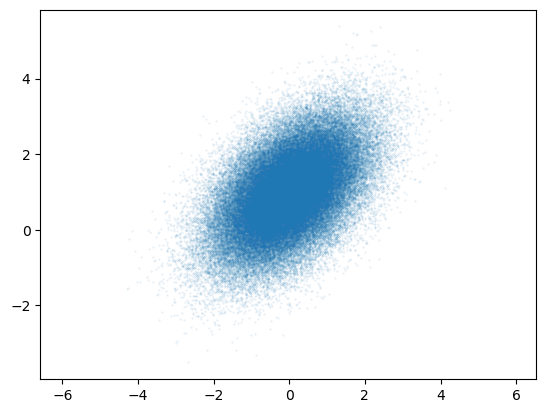

In [21]:
plt.scatter(rd[:, 0], rd[:, 1], s = 0.1, alpha=0.2)
plt.axis('equal')